Apply the methodology in Solodoch et al., 2023 without removing trend/seasonal components.

In [6]:
import pickle
import sys; sys.path.append("../models")
import utils
import train
from SOLODOCH import MLP

import xarray as xr
import numpy as np

import torch as t
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

device = "cuda" if t.cuda.is_available() else "cpu"
t.manual_seed(123456)

In [7]:
gdrive = "/mnt/g/My Drive/GTC"
data_home = f"{gdrive}/ecco_data_minimal"
sections = ["26N", "30S", "55S", "60S"]
coordinates = ["time", "latitude", "longitude"]
vars = ["SSH", "SST", "SSS", "OBP", "ZWS"]

In [8]:
train.batch_size = 16
train.max_iters = 10000
train.lr = 1e-2
train.weight_decay = 1e-3

all_moc = []; all_pred = []
all_rmse = []; all_mape = []; all_mape_ = []
for section in sections:
    # load input data
    data = xr.open_dataset(f"{data_home}/{section}.nc").transpose(*coordinates)

    # choose the single latitude we are modelling (middle)
    data = data.isel(latitude=[1])
    # remove empty coords
    all_nan = data.isnull().all(dim=["time", "latitude"])
    data = data.where(~all_nan, drop=True)
    # grab coordinates
    times = data.time.values
    latitudes = data.latitude.values
    longitudes = data.longitude.values

    # split into training/validation/testing data
    trainval_split = int(0.6*data.sizes["time"])
    valtest_split = int(0.8*data.sizes["time"])
    train_data = data.isel(time=slice(0, trainval_split))
    val_data = data.isel(time=slice(trainval_split, valtest_split))
    test_data = data.isel(time=slice(valtest_split, data.sizes["time"]))

    # load output data
    with open(f"{gdrive}/moc/single_lats/{section}_moc_density.pickle", "rb") as f:
        moc = pickle.load(f)
    y_train = t.Tensor(moc[:trainval_split])
    y_val = t.Tensor(moc[trainval_split:valtest_split])
    y_test = t.Tensor(moc[valtest_split:])

    def get_X(data, keep_coords, data_vars, history=None, return_pt=True, verbose=False):
        pp_data = utils.reshape_inputs(data,
                                    keep_coords=keep_coords,
                                    data_vars=data_vars,
                                    return_pt=return_pt, verbose=verbose)
        if "ZWS" in data_vars:
            # specific for solodoch setup:
            # last feature is wind stress, so we can calculate zonal averages
            zws = t.nanmean(pp_data[..., -1], dim=-1)
            pp_data = pp_data[..., :-1]
            X = t.cat([pp_data.reshape(pp_data.shape[0], -1), zws.unsqueeze(-1)], dim=-1)
        else:
            X = pp_data.reshape(pp_data.shape[0], -1)

        return X

    data_vars = ["OBP"]
    keep_coords = ["time", "longitude"]
    hd = 1
    X_train = get_X(train_data, keep_coords, data_vars, None, True, False)
    X_val = get_X(val_data, keep_coords, data_vars, None, True, False)
    X_test = get_X(test_data, keep_coords, data_vars, None, True, False)

    # standardise inputs
    m = X_train.mean(axis=tuple(np.arange(X_train.ndim-1)))
    std = X_train.std(axis=tuple(np.arange(X_train.ndim-1)))
    X_train = (X_train - m[..., :]) / std[..., :]
    X_val = (X_val - m[..., :]) / std[..., :]
    X_test = (X_test - m[..., :]) / std[..., :]

    model = MLP(n_features=X_train.shape[-1],
                hidden_dim_width=hd).to(device)

    model, train_loss, val_loss = train.train_model(model, X_train, y_train, X_val=X_val, y_val=y_val, early_stopping=True)
    y_pred = model(X_test.to(device))
    test_loss = F.mse_loss(y_pred.squeeze(-1), y_test.to(device)).item()
    mape = (t.mean(t.abs((y_test.to(device) - y_pred.squeeze(-1))/y_test.to(device)))*100).item()

    ixs = (t.abs(y_test) > 0.5).nonzero().flatten()
    y_test_ = y_test[ixs]
    y_pred_ = y_pred.squeeze(-1)[ixs].cpu()
    mape_ = t.mean(t.abs((y_test_ - y_pred_)/y_test_)*100).item()

    X = t.cat([X_train, X_val, X_test], dim=0)
    Y = t.cat([y_train, y_val, y_test], dim=0)
    full_pred = model(X.to(device)).squeeze(-1)
    full_pred = full_pred.detach().cpu().numpy()

    all_rmse.append(np.sqrt(test_loss)); all_mape.append(mape); all_mape_.append(mape_)
    all_moc.append(Y); all_pred.append(full_pred)

device: cuda
167 parameters.


  0%|          | 46/10000 [00:00<01:01, 161.64it/s]

100%|██████████| 10000/10000 [00:50<00:00, 196.59it/s]


device: cuda
577 parameters.


 18%|█▊        | 1840/10000 [00:09<00:42, 191.82it/s]


early stopping
device: cuda
709 parameters.


100%|██████████| 10000/10000 [00:53<00:00, 186.91it/s]


device: cuda
723 parameters.


100%|██████████| 10000/10000 [00:53<00:00, 185.62it/s]


In [9]:
print(all_rmse)
print(all_mape)
print(all_mape_)

[0.5976039389860923, 7.658162279124686, 4.77046453169338, 8.121975849460448]
[87.863525390625, 44.23095703125, 56.14865493774414, 95.1736831665039]
[39.443885803222656, 44.230953216552734, 56.14864730834961, 69.25609588623047]


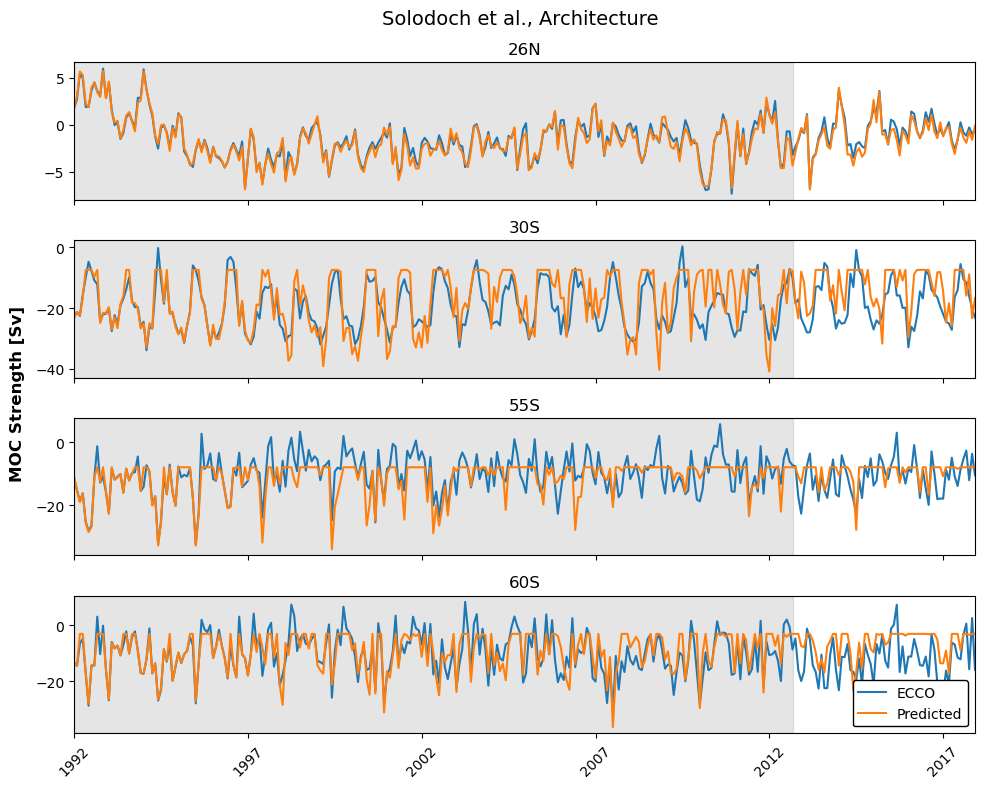

In [16]:
fig, axs = plt.subplots(nrows=4, ncols=1, sharex=True, squeeze=True, figsize=(10, 8))
for ax, moc, full_pred, section in zip(axs, all_moc, all_pred, sections):
    ax.plot(moc, label="ECCO")
    ax.plot(full_pred, label="Predicted")
    y_lower, y_upper = ax.get_ylim()
    x_pos = np.arange(len(X) - len(X_test))
    ax.fill_between(x = x_pos, 
                    y1 = np.repeat(y_lower, len(x_pos)), 
                    y2 = np.repeat(y_upper, len(x_pos)),
                    alpha = 0.2, 
                    color = 'gray')
    ax.margins(x = 0, y = 0)
    ax.set_title(section)
ax.set_xticks(np.arange(0, 324, 60), np.arange(1992, 2019, 5), rotation=45)
ax.legend(loc = 'lower right', edgecolor = 'black', framealpha = 1)
fig.supylabel("MOC Strength [Sv]", weight="bold")
fig.suptitle("Solodoch et al., Architecture", fontsize=14, x=0.53)
plt.tight_layout()
plt.savefig(f"plots/rawmoc.png", dpi=400)
plt.show()